In [123]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import pandas as pd
import timm 
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from glob import glob
from PIL import Image
from openpyxl import Workbook
from openpyxl.drawing.image import Image as OpenImage
from openpyxl.chart import BarChart, Reference
from io import BytesIO
import json

In [124]:
URL = 'Food'
BATCHSIZE = 32
RETRAIN = False

In [125]:
json_files = [pos_json for pos_json in os.listdir(f'dataset/{URL}/') if pos_json.endswith('.json')]

with open(f'dataset/{URL}/{json_files[0]}', 'r') as json_file:
  data_file = json.load(json_file)

NUMCLASSES = data_file['NumClasses']
SAVEPATH = data_file['SavePath']
MODELNAME = data_file['ModelName']

['food.json']


In [126]:
class PlayCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [127]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes=NUMCLASSES):
        super(SimpleCardClassifier, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        # self.base_model = timm.create_model('efficientnet_b1_pruned', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        enet_out_size = 1280
        self.classifier = nn.Sequential( 
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [128]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = f'dataset/{URL}/train/'
valid_folder = f'dataset/{URL}/valid/'
test_folder = f'dataset/{URL}/test/'

dataset = PlayCardDataset(train_folder)
train_dataset = PlayCardDataset(train_folder, transform=transform)
valid_dataset = PlayCardDataset(valid_folder, transform=transform)
test_dataset = PlayCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCHSIZE, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False)

In [129]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [130]:
num_epoch = 5
train_losses, val_losses = [], []

if os.path.exists(f'{MODELNAME}.pt') and RETRAIN == False:
    model = torch.load(f'{MODELNAME}.pt')

else:
    model = SimpleCardClassifier(num_classes=NUMCLASSES)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epoch):
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc='Training loop'):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * labels.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for images, labels in tqdm(valid_loader, desc='Validation loop'):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * labels.size(0)
            val_loss = running_loss / len(valid_loader.dataset)
            val_losses.append(val_loss)

            print(f"Epoch {epoch+1}/{num_epoch} - Training loss: {train_loss}, Validation loss: {val_loss}")
        
    torch.save(model, f'{MODELNAME}.pt')

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, ke

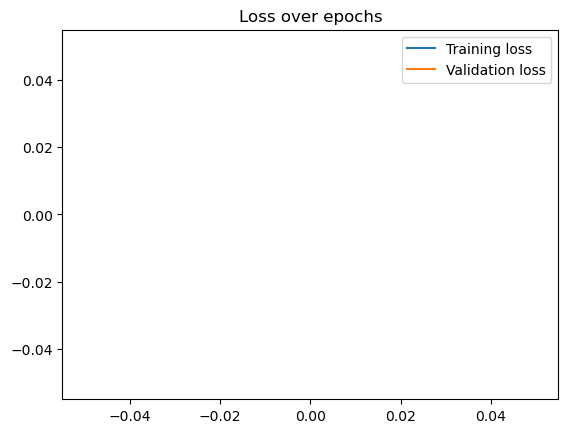

In [131]:
print(model)
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [132]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilites = torch.nn.functional.softmax(outputs, dim=1)
    
    return probabilites.cpu().numpy().flatten()

def visualize_predictions(original_image, probabilities, class_names):
    data = {'Class Name': class_names, 'Probability': probabilities}
    df = pd.DataFrame(data)

    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout
    plt.show()

In [133]:
def convert_to_workbook(images, probabilities_batch, class_names):
  wb = Workbook()
  ws = wb.active
  row_counter = 1

  for idx, (original_image, probabilities) in enumerate(zip(images, probabilities_batch), start=1):
    ws = wb.create_sheet(title=f"Image_{idx}")
    row_counter = 1
    
    img_buffer = BytesIO()
    original_image.save(img_buffer, format='png')
    img = OpenImage(img_buffer)
    ws.add_image(img, f'A{row_counter}')

    ws.cell(row=row_counter, column=3).value = "Class Name"
    ws.cell(row=row_counter, column=4).value = "Probability"

    for i, (class_name, probability) in enumerate(zip(class_names, probabilities), start=1):
      ws.cell(row=row_counter + i, column=3).value = class_name
      ws.cell(row=row_counter + i, column=4).value = probability

    chart = BarChart()
    data = Reference(ws, min_col=4, min_row=1, max_row=len(class_names) + 1, max_col=4)
    categories = Reference(ws, min_col=3, min_row=2, max_row=len(class_names) + 1, max_col=3)
    chart.add_data(data, titles_from_data=True)
    chart.set_categories(categories)
    chart.title = "Class Predictions"
    ws.add_chart(chart, "D1")

  wb.save(f'{SAVEPATH}.xlsx')

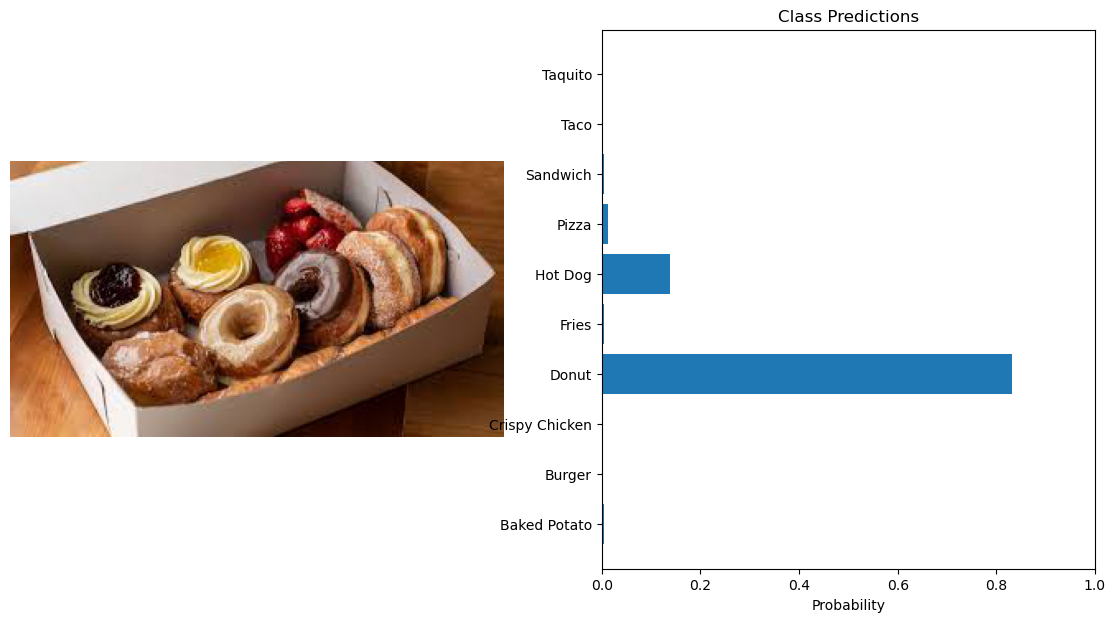

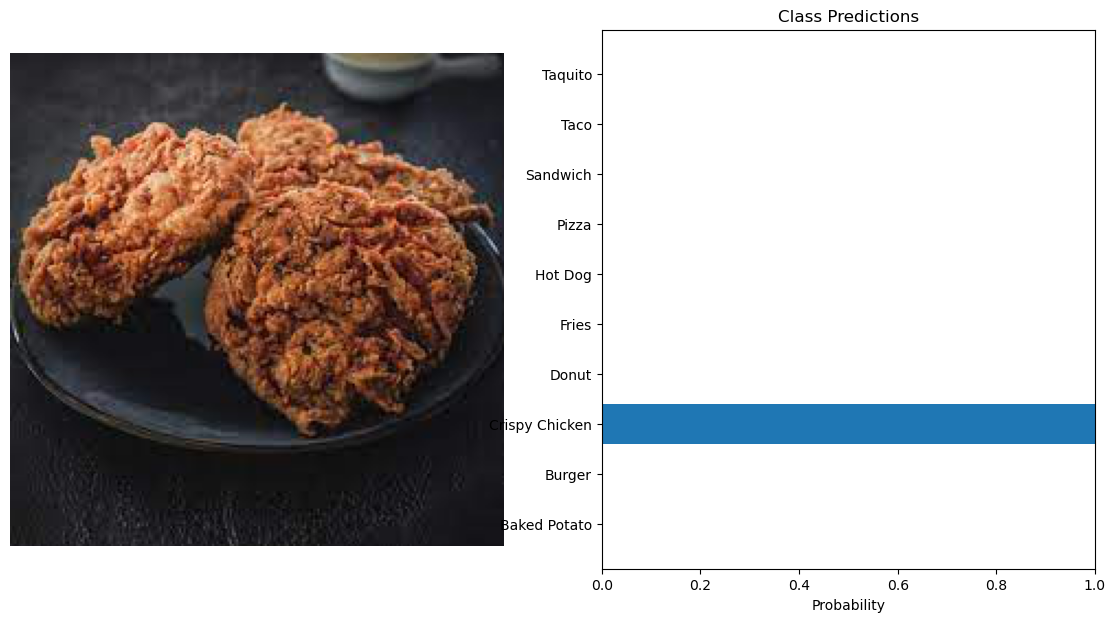

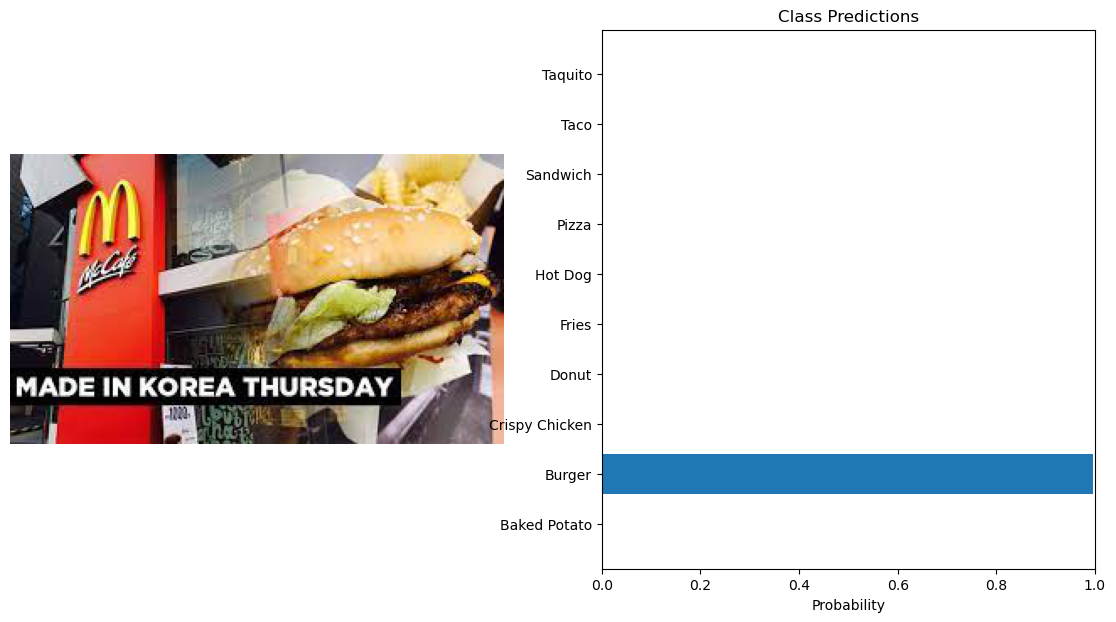

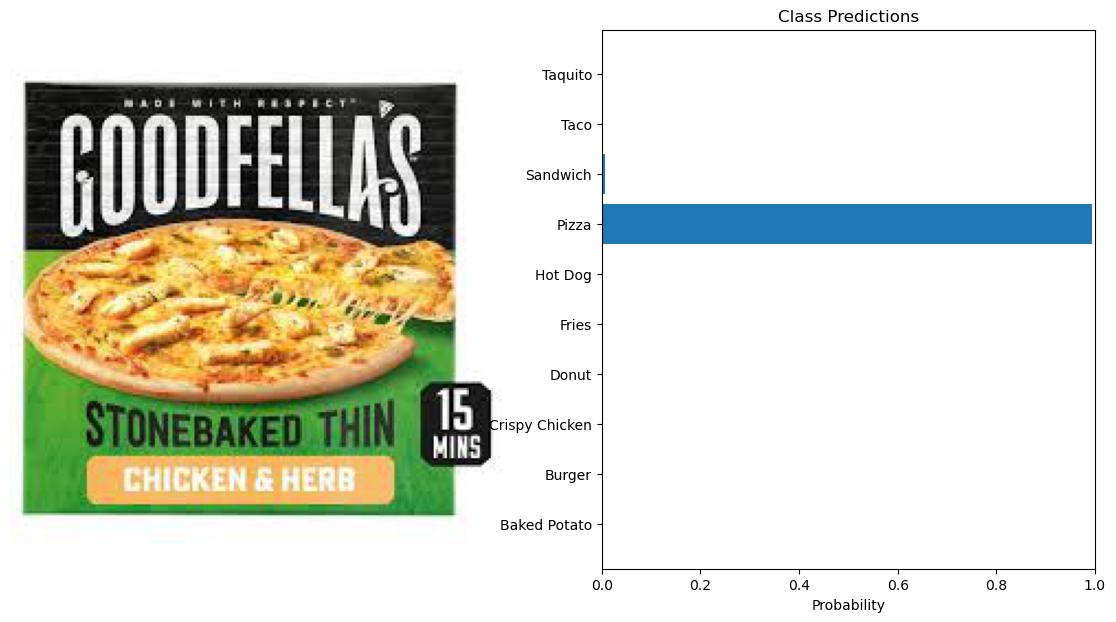

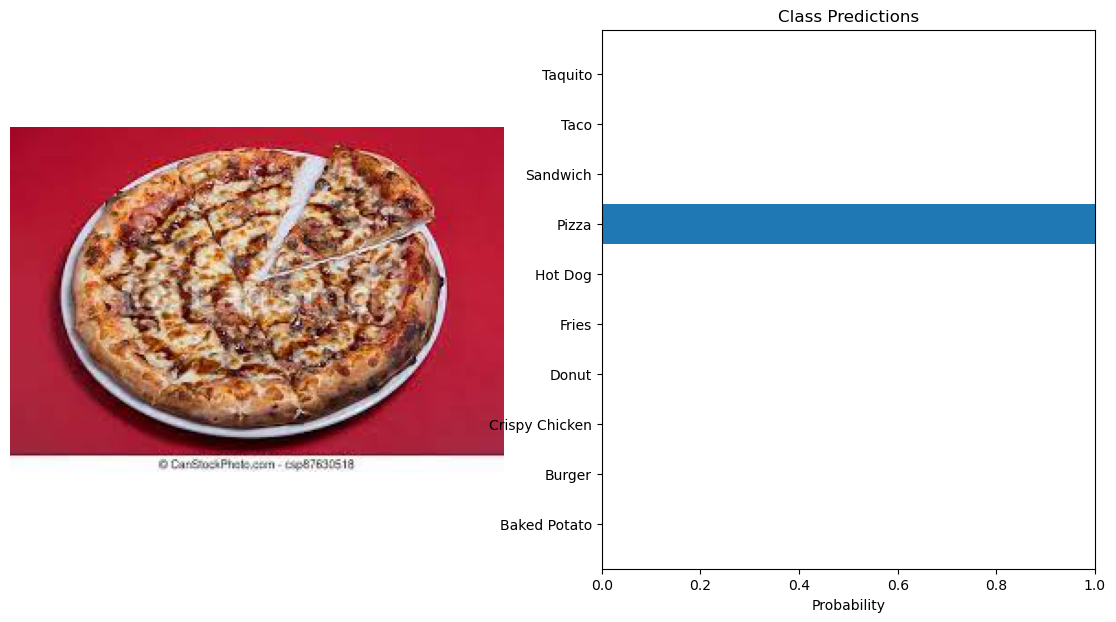

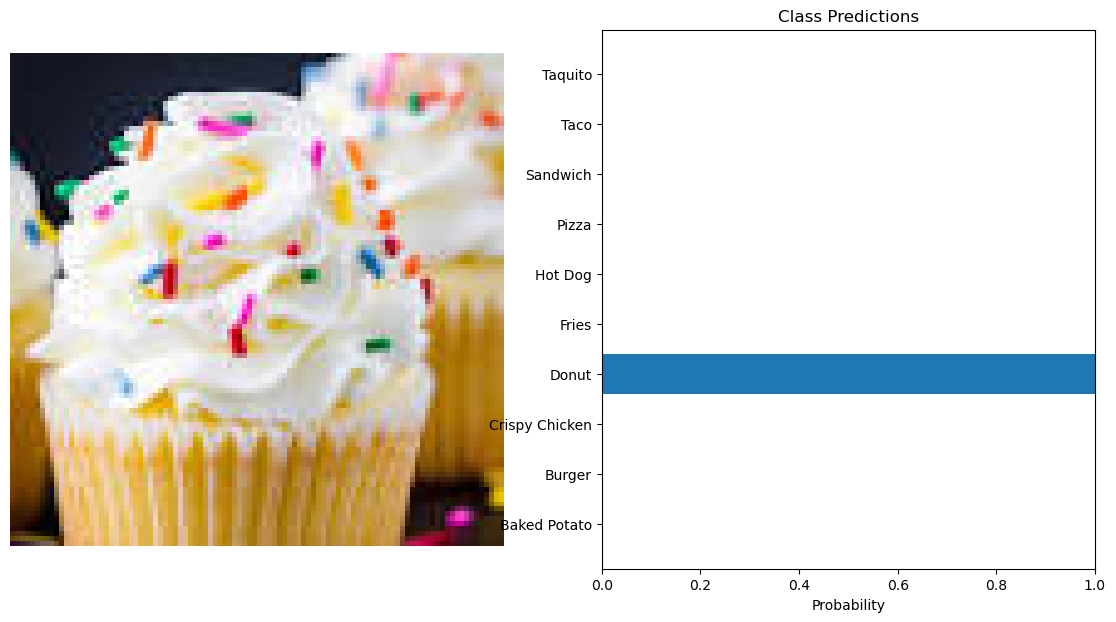

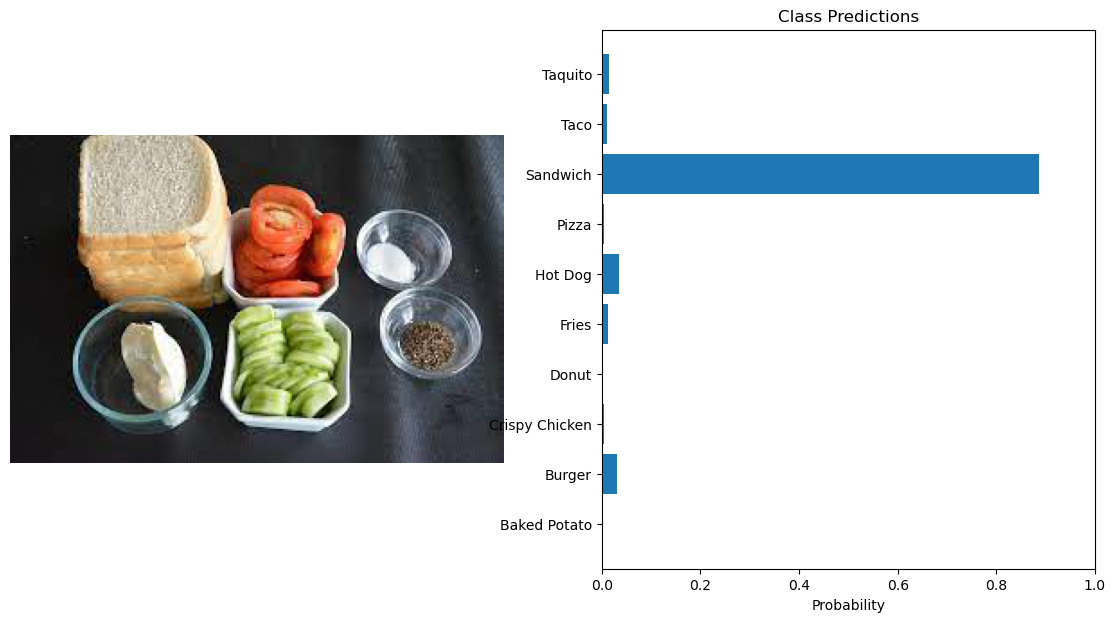

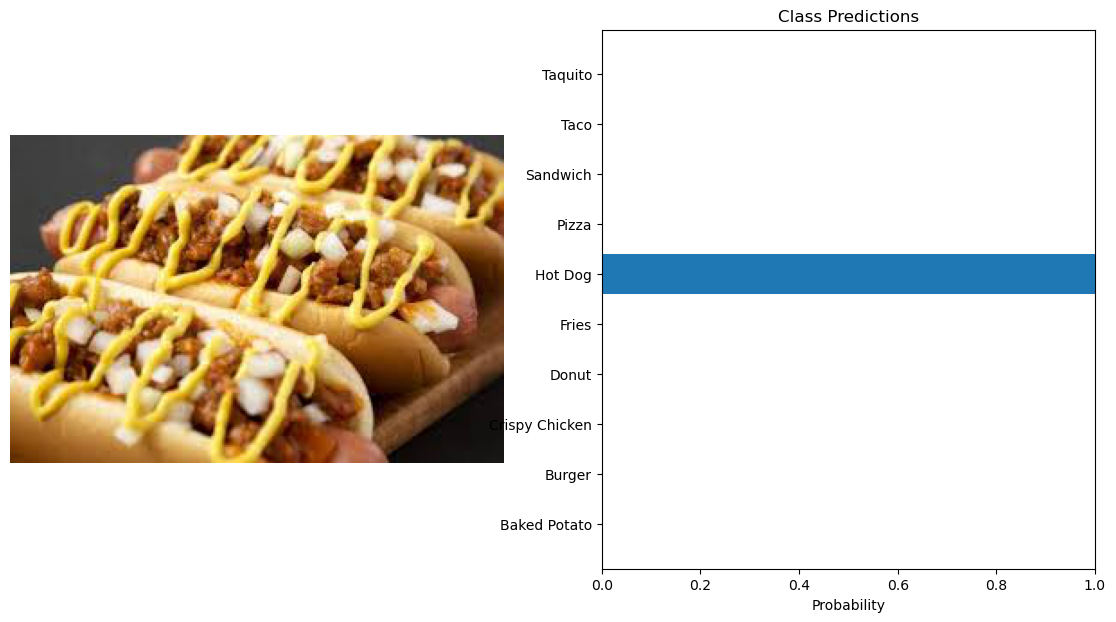

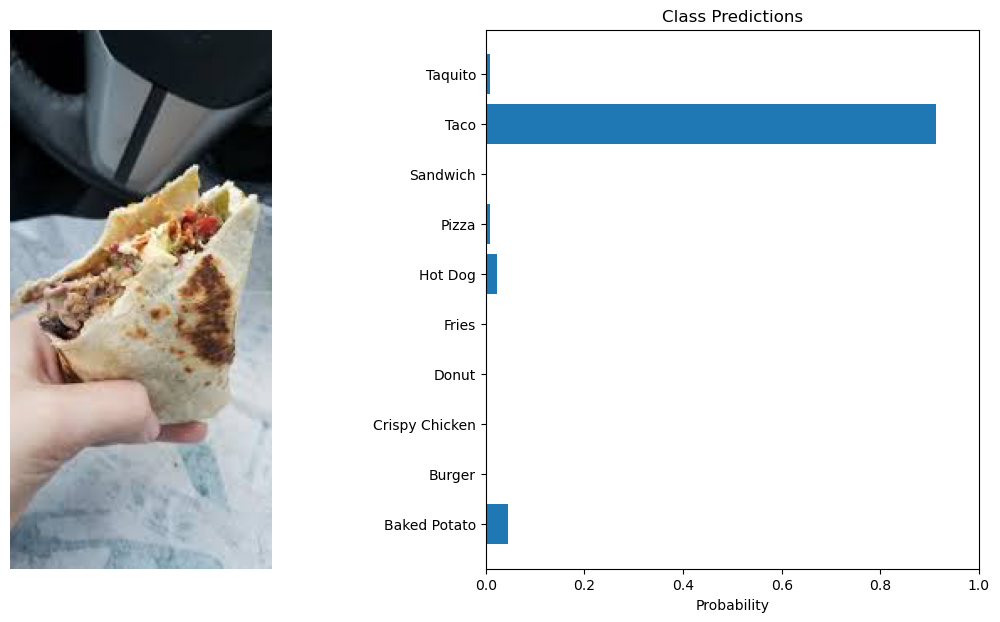

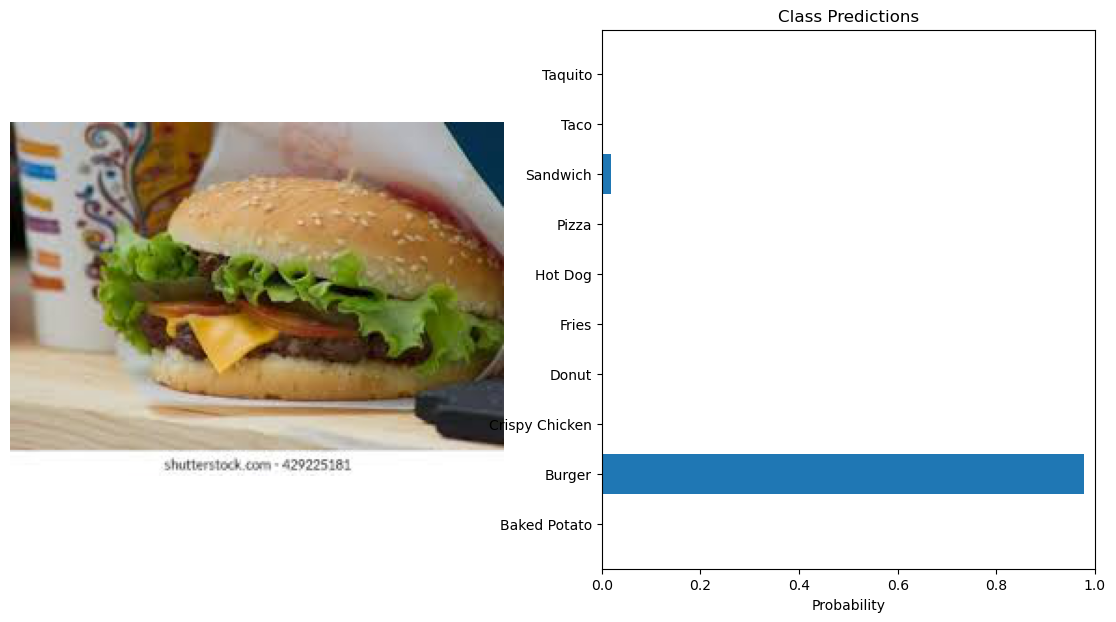

In [134]:
test_images = glob(f'dataset/{URL}/test/*/*')
test_examples = np.random.choice(test_images, 10)

images = []
probabilities_batch = []

for example in test_examples:
    original_image, image_tensor = preprocess_image(example)
    probabilities = predict(model, image_tensor, device)

    images.append(original_image)
    probabilities_batch.append(probabilities)

    class_names = test_dataset.classes

    visualize_predictions(original_image, probabilities, class_names)

In [135]:
# images
# probabilities_batch
convert_to_workbook(images, probabilities_batch, test_dataset.classes)